# Εκπαίδευση Μοντέλου DenseNet, ResNet, EfficientNet
μοντέλο  με ακτινογραφίες σε gray-scale,

In [1]:
from google.colab import drive
drive.mount('/content/drive')

NotImplementedError: Mounting drive is unsupported in this environment. Use PyDrive instead. See examples at https://colab.research.google.com/notebooks/io.ipynb#scrollTo=7taylj9wpsA2.

### **Βιβλιοθήκες που απαιτούνται**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import tensorflow as tf # Import TensorFlow here



Ορισμός path και φόρτωση των label
δημιουργία dictionary για την βαρύτητα των κατηγοριών

In [ ]:
# Set paths for training and testing data
train_data_dir = '/content/drive/MyDrive/ML102/train_images/train_images'
test_data_dir  = '/content/drive/MyDrive/ML102/test_images_all'
labels_file    = '/content/drive/MyDrive/ML102/labels_train.csv'
models = ['DensNet','ResNet','EfficientNet']

# Φόρτωση του αρχείου labels
labels = pd.read_csv(labels_file)
labels['class_id'] = labels['class_id'].astype(str)  # Μετατροπή σε string για χρήση με ImageDataGenerator

# Υπολογισμός βαρύτητας ανά κατηγορία
class_weights = labels['class_id'].value_counts(normalize=True).to_dict()

### Προαιτημασία δεδομένων

In [ ]:
# Χρήση φίλτρου CLAHE
def preprocess_with_clahe(image):
    # Μετατροπή της εικόνας σε uint8
    image = (image * 255).astype(np.uint8)

    # Εφαρμογή CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)

    # Επιστροφή της εικόνας σε float32 με σχήμα (224, 224, 1)
    enhanced_image = np.expand_dims(enhanced_image, axis=-1)  # Προσθήκη καναλιού για grayscale
    return enhanced_image / 255.0

def preprocess_to_rgb(image):
    # Εάν η εικόνα είναι grayscale (1 κανάλι), μετατρέψτε την σε RGB (3 κανάλια)
    if len(image.shape) == 3 or image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    return image
IMG_SIZE = 224

batch_size = 64
# Δημιουργία ImageDataGenerator για εκπαίδευση και επικύρωση

# Βελτιωμένο data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_with_clahe,  # Χρήση της ενημερωμένης συνάρτησης
    validation_split=0.2,
    rotation_range=50,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=train_data_dir,
    x_col='file_name',
    y_col='class_id',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=train_data_dir,
    x_col='file_name',
    y_col='class_id',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation'
)

Found 3738 validated image filenames belonging to 3 classes.
Found 934 validated image filenames belonging to 3 classes.


In [ ]:
!pip uninstall torch
!pip install torch==2.5.1+cu124 --extra-index-url https://download.pytorch.org/whl/cu124

In [ ]:
!pip install datasets


## Create and Train Model

In [ ]:
import tensorflow as tf
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
from time import strftime
from tensorflow.keras.models import Sequential, Model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import DenseNet121, ResNet50V2, EfficientNetB3
from tensorflow.keras.layers import Input, Conv2D,  Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import TrainingArguments, Trainer
from datasets import load_dataset
from transformers import ViTForImageClassification, ViTFeatureExtractor

import numpy as np
from tensorflow.keras.optimizers import Nadam

def create_model(model_name, train_generator, validation_generator, class_weights, epochs=20):

    input_tensor = Input(shape=(224, 224, 1))
    x = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(input_tensor)

    if model_name == 'DenseNet':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=x)
    elif model_name == 'ResNet':
        base_model = ResNet50V2(weights='imagenet', include_top=False, input_tensor=x)
    elif model_name == 'EfficientNet':
        base_model = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=x)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.2)(x)
    x = Dense(3, activation='softmax')(x)


    model = Model(inputs=input_tensor, outputs=x)

    # Βελτιωμένος optimizer με learning rate scheduler
    optimizer = Nadam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    from tensorflow.keras.callbacks import ReduceLROnPlateau
    model_file=f"/content/drive/MyDrive/ML102/Kmodels/Pnevmonia_MLP_{model_name}.keras"

    dt = datetime.now().strftime("%Y%m%d-%H%M%S")
    dt1 = datetime.now()
    print(f"Start At: {dt}")
    log_dir=f"/content/drive/MyDrive/ML102/log_dir/K{dt}"
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f"best_{model_name}.keras", monitor='val_accuracy', save_best_only=True, mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

    # Εκπαίδευση του μοντέλου
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,  # Ορίσμός εποχών
        class_weight=class_weights,  # πάρε υποψην την βαρήτητα συμμετοχής των κλασεων
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping, model_checkpoint, reduce_lr, tensorboard_callback]
    )
    #Αναμενόμενα Αποτελέσματα
    model.save(model_file)
    dt2 = datetime.now()
    print(f"Start at: {dt1} End at :{dt2} Duration : {dt2-dt1}")
    # Εκτύπωση summary του μοντέλου
    return model, history
#
#
# Model Plot Function
#
def plot_results(selection, model, history):

    # Αξιολόγηση του μοντέλου
    loss, accuracy = model.evaluate(validation_generator)
    print(f"## Model **{selection}**")
    print(f'Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}')
    # Οπτικοποίηση της ακρίβειας και της απώλειας
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    # Εκτύπωση τελικών αποτελεσμάτων

    val_accuracy = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]
    print (f"--------- {selection} --------------------")
    print(f'Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}')



### **Run training**

In [ ]:
md_name='DenseNet'
modelDessNet, historyDenseNet = create_model(md_name,train_generator, validation_generator, class_weights, epochs=50)
plot_results(md_name, modelDessNet, historyDenseNet)
md_name='ResNet'
modelResNet, historyResNet = create_model(md_name,train_generator, validation_generator, class_weights, epochs=50)
plot_results(md_name, modelDessNet, historyDenseNet)
md_name='EfficientNet'
modelEfficientNet, historyEfficientNet = create_model(md_name,train_generator, validation_generator, class_weights, epochs=50)
plot_results(md_name, modelDessNet, historyDenseNet)



### Αξιολόγηση Μοντέλου

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data_dir  = '/content/drive/MyDrive/ML102/test_images_all' # Assuming your test images are in this directory
test_generator = test_datagen.flow_from_directory(
    test_data_dir, # Use the correct path for your test images
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode=None,
    shuffle=False
)

predictions = modelEfficientNet.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

results_df = pd.DataFrame({'file_name': test_generator.filenames, 'predicted_class': predicted_classes})
results_df.to_csv('/content/drive/MyDrive/ML102/train_csvs/KPnevmonia_EfficientMet_v2.csv', index=False)

In [ ]:
!pip install scikit-learn

## AdaBoost Implementation

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier # Import DecisionTreeClassifier

# Εκπαίδευση AdaBoost με τα μοντέλα
def adaboost_model(model):
    # Initialize AdaBoostClassifier with DecisionTreeClassifier as base_estimator
    # and remove 'base_estimator' argument
    adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)

    X_train, y_train = next(train_generator)
    X_val, y_val = next(validation_generator)

    # Reshape the data for AdaBoostClassifier
    # You might need to adjust this based on your model's output
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_val_reshaped = X_val.reshape(X_val.shape[0], -1)

    # Extract features using the pre-trained model
    X_train_features = model.predict(X_train)
    X_val_features = model.predict(X_val)

    # Train AdaBoostClassifier
    adaboost.fit(X_train_features, np.argmax(y_train, axis=1)) # Use argmax to get class labels

    # Make predictions and calculate accuracy
    y_pred = adaboost.predict(X_val_features)
    accuracy = accuracy_score(np.argmax(y_val, axis=1), y_pred) # Use argmax to get class labels
    adaboost.
    return adaboost, accuracy

In [ ]:
densenet_adaboost, densenet_accuracy = adaboost_model(modelDessNet)
resnet_adaboost, resnet_accuracy = adaboost_model(modelResNet)
efficientnet_adaboost, efficientnet_accuracy = adaboost_model(modelEfficientNet)

print("DenseNet AdaBoost Accuracy:", densenet_accuracy)
print("ResNet101 AdaBoost Accuracy:", resnet_accuracy)
print("EfficientNet AdaBoost Accuracy:", efficientnet_accuracy)



2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
DenseNet AdaBoost Accuracy: 0.734375
ResNet101 AdaBoost Accuracy: 0.796875
EfficientNet AdaBoost Accuracy: 0.6875


## Υλοποίηση Committee Machines

In [ ]:
# Αποθήκευση μοντέλων
import joblib

joblib.dump(densenet_adaboost, 'densenet_adaboost.joblib')
joblib.dump(resnet_adaboost, 'resnet_adaboost.joblib')
joblib.dump(efficientnet_adaboost, 'efficientnet_adaboost.joblib')

# Εκτέλεση μοντέλων σε δεδομένα test
test_dir = '/content/drive/MyDrive/ML102/test_images_all'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode=None,
    shuffle=False
)

for batch in test_generator:
    print(batch[0].shape)  # Print the shape of the input images
    break

Found 1168 images belonging to 1 classes.
(224, 224, 1)


In [ ]:
def predict_and_save(model, model_name):
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)

    test_filenames = test_generator.filenames
    results = pd.DataFrame({'file_name': test_filenames, 'class_id': predicted_classes})
    results.to_csv(f'/content/drive/MyDrive/ML102/train_csvs/K_{model_name}_predictions.csv', index=False)

predict_and_save(modelDessNet, 'DenseNet')
predict_and_save(modelResNet, 'ResNet101')
predict_and_save(modelEfficientNet, 'EfficientNet')

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 448ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 420ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step


In [ ]:


# Προβλέψεις από τα τρία μοντέλα
predictions_densenet = modelDessNet.predict(test_generator)
predictions_resnet = modelResNet.predict(test_generator)
predictions_efficientnet = modelEfficientNet.predict(test_generator)

# Μετατροπή σε κατηγορίες
classes_densenet = np.argmax(predictions_densenet, axis=1)
classes_resnet = np.argmax(predictions_resnet, axis=1)
classes_efficientnet = np.argmax(predictions_efficientnet, axis=1)

# Συνδυασμός προβλέψεων με πλειοψηφία
final_predictions = []
for i in range(len(classes_densenet)):
    votes = [classes_densenet[i], classes_resnet[i], classes_efficientnet[i]]
    final_predictions.append(max(set(votes), key=votes.count))  # Πλειοψηφία

37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step


In [ ]:
# Συνδυασμός προβλέψεων με μέσο όρο
average_predictions = (predictions_densenet + predictions_resnet + predictions_efficientnet) / 3
final_predictions = np.argmax(average_predictions, axis=1)

In [ ]:
results_df = pd.DataFrame({'file_name': test_generator.filenames, 'predicted_class': final_predictions})
results_df.to_csv('/content/drive/MyDrive/ML102/train_csvs/k_committee_predictions.csv', index=False)

In [ ]:
# Υπολογισμός ακρίβειας
validation_predictions = []
for model in [modelDessNet, modelResNet, modelEfficientNet]:
    predictions = model.predict(validation_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    validation_predictions.append(predicted_classes)
    accuracy = np.mean(predicted_classes == validation_generator.classes)
    print(f'Validation Accuracy for {model.name}: {accuracy:.4f}')

# Ensure validation_predictions is a NumPy array before averaging
validation_predictions = np.array(validation_predictions)
average_predictions = np.mean(np.array(validation_predictions), axis=0)  # Average validation predictions
final_predictions = np.round(average_predictions).astype(int)  # Convert to class labels

true_labels = validation_generator.classes  # Πραγματικές ετικέτες

# Make sure final_predictions and true_labels are the same length
min_len = min(len(final_predictions), len(true_labels))
final_predictions = final_predictions[:min_len]
true_labels = true_labels[:min_len]

accuracy = np.mean(final_predictions == true_labels)
print(f'Committee Machine Validation Accuracy: {accuracy:.4f}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 636ms/step
Validation Accuracy for functional_27: 0.3662
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 637ms/step
Validation Accuracy for functional_28: 0.3662
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 634ms/step
Validation Accuracy for functional_29: 0.3651
Committee Machine Validation Accuracy: 0.4251


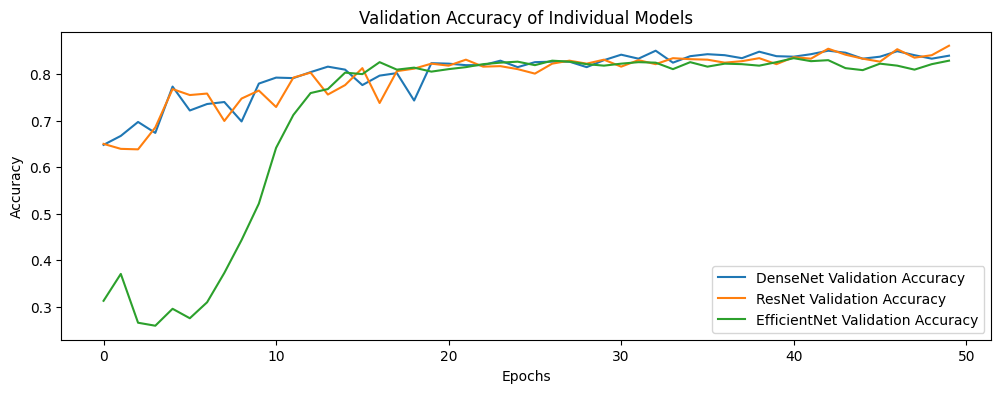

In [ ]:
# Διαγράμματα ακρίβειας
plt.figure(figsize=(12, 4))
plt.plot(historyDenseNet.history['val_accuracy'], label='DenseNet Validation Accuracy')
plt.plot(historyResNet.history['val_accuracy'], label='ResNet Validation Accuracy')  # Changed history_resnet to historyResNet
plt.plot(historyEfficientNet.history['val_accuracy'], label='EfficientNet Validation Accuracy')  # Changed history_efficientnet to historyEfficientNet
plt.title('Validation Accuracy of Individual Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Φόρτωση των εκπαιδευμένων μοντέλων

In [ ]:
from tensorflow.keras.models import load_model

# Φόρτωση των εκπαιδευμένων μοντέλων
model_densenet = load_model('/content/drive/MyDrive/ML102/models/K_Pnevmonia_MLP_DenseNet.keras')
model_resnet = load_model('/content/drive/MyDrive/ML102/models/K_Pnevmonia_MLP_ResNet.keras')
model_efficientnet = load_model('/content/drive/MyDrive/ML102/models/K_Pnevmonia_MLP_EfficientNet.keras')